<a href="https://colab.research.google.com/github/hadiwyne/sentiment_analysis/blob/main/sentiment_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!pip install ebooklib bs4 nltk wordcloud spacy requests matplotlib scikit-learn seaborn

# Download Models and Data

In [2]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import spacy
try:
    spacy.load('en_core_web_sm')
except OSError:
    !python -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Imports

In [3]:
import io
from ebooklib import epub, ITEM_DOCUMENT
from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from heapq import nlargest
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import tempfile
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from IPython.display import Image, display
from google.colab import files
import textwrap

# Configure OpenRouter API

In [24]:
api_key = "" #Add your own key
endpoint = "https://openrouter.ai/api/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# Functions for parsing and analysis

In [5]:
def parse_epub(file_bytes):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".epub") as tmp:
        tmp.write(file_bytes)
        tmp_path = tmp.name
    book = epub.read_epub(tmp_path)
    raw = []
    for item in book.get_items():
        if item.get_type() == ITEM_DOCUMENT:
            soup = BeautifulSoup(item.get_content(), 'html.parser')
            for p in soup.find_all('p'):
                raw.append(p.get_text())
    text = '\n'.join(raw)
    text = re.sub(r"\s+", ' ', text)
    sentences = sent_tokenize(text)
    return sentences, text

# Function for Wordcloud

In [6]:
def generate_wordcloud(corpus):
    stopwords = set(STOPWORDS)
    wc = WordCloud(width=600, height=300, background_color='white', stopwords=stopwords)
    img = wc.generate(corpus)
    buf = io.BytesIO()
    plt.figure(figsize=(6,3))
    plt.imshow(img, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close()
    return buf.getvalue()

# Function for Sentiment Analysis Pie Chart

In [7]:
def sentiment_pie(sentences):
    sid = SentimentIntensityAnalyzer()
    counts = {'positive':0,'negative':0,'neutral':0}
    for s in sentences:
        score = sid.polarity_scores(s)['compound']
        if score>=0.05: counts['positive']+=1
        elif score<=-0.05: counts['negative']+=1
        else: counts['neutral']+=1
    buf = io.BytesIO()
    plt.figure(figsize=(4,4))
    plt.pie(list(counts.values()), labels=list(counts.keys()), autopct='%1.1f%%')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close()
    return buf.getvalue()

# LLM Function

In [8]:
def llm_summary(text_chunk, max_tokens=512):
    data = {"model":"mistralai/mistral-7b-instruct",
            "messages":[{"role":"user","content":f"Please provide a concise summary of the following text:\n{text_chunk}"}],
            "max_tokens":max_tokens,
            "temperature":0.7}
    r = requests.post(endpoint, headers=headers, json=data)
    r.raise_for_status()
    return r.json()['choices'][0]['message']['content'].strip()

# Summarizer Function

In [9]:
class Summarizer:
    def __init__(self,sentences,fraction=0.002):
        self.sentences=sentences; self.fraction=fraction
        self.nlp=spacy.load('en_core_web_sm')
        self.doc=self.nlp(' '.join(sentences))
        self.stop=set(STOP_WORDS)|set(punctuation)
        self.freq={}; self.score={}
    def compute_frequencies(self):
        for t in self.doc:
            w=t.text.lower()
            if w in self.stop: continue
            self.freq[w]=self.freq.get(w,0)+1
        m=max(self.freq.values()) if self.freq else 1
        for w in self.freq: self.freq[w]/=m
    def score_sentences(self):
        for sent in self.doc.sents:
            for t in sent:
                w=t.text.lower()
                if w in self.freq: self.score[sent]=self.score.get(sent,0)+self.freq[w]
        return list(self.doc.sents)
    def summarize(self,top_n=3):
        self.compute_frequencies(); sents=self.score_sentences()
        top=nlargest(top_n,self.score,key=self.score.get)
        return [str(s).strip() for s in top]

# Preprocess Text

In [10]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return ' '.join(tokens)

# Classification Model Function

In [22]:
def run_classification_model(text):
    processed = preprocess_text(text)
    sentences = sent_tokenize(text)
    labels = []
    for s in sentences:
        score = SentimentIntensityAnalyzer().polarity_scores(s)['compound']
        if score >= 0.05:
            labels.append("positive")
        elif score <= -0.05:
            labels.append("negative")
        else:
            labels.append("neutral")
    df = pd.DataFrame({"text":sentences, "label":labels})
    X = df['text'].apply(preprocess_text)
    y = df['label']
    vectorizer = TfidfVectorizer()
    X_vect = vectorizer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "Naive Bayes": MultinomialNB()
    }

    reports = {}
    model_preds = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        cm = confusion_matrix(y_test, preds)
        report = classification_report(y_test, preds, output_dict=True)
        reports[name] = {"accuracy": acc, "confusion_matrix": cm, "report": report}
        model_preds[name] = preds

    return reports, model_preds

# Classification Pie Function

In [12]:
def classification_sentiment_pie(model_preds):
    for name, preds in model_preds.items():
        counts = pd.Series(preds).value_counts().to_dict()
        labels = list(counts.keys())
        sizes = list(counts.values())

        buf = io.BytesIO()
        plt.figure(figsize=(4, 4))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%')
        plt.title(f"{name} Sentiment Distribution")
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig(buf, format='png')
        plt.close()
        display(Image(data=buf.getvalue()))

# Upload EPUB

In [13]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
with open(file_name, "rb") as f:
    file_bytes = f.read()

sentences, text_full = parse_epub(file_bytes)
corpus = ' '.join([s.lower() for s in sentences])

Saving space_of_literature.epub to space_of_literature (1).epub


# Word Cloud

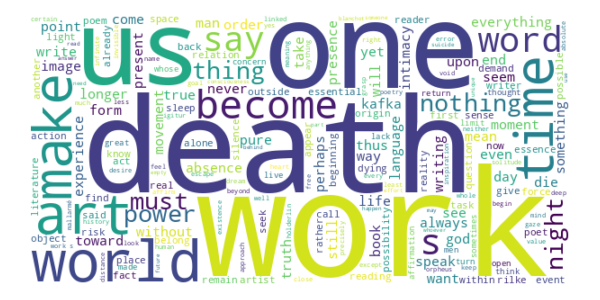

In [16]:
wc_img = generate_wordcloud(corpus)
display(Image(data=wc_img))

# Sentiment Pie

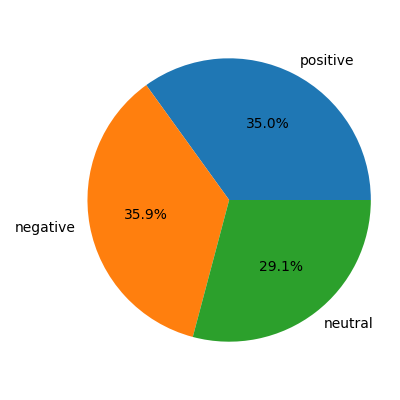

In [17]:
pie_img = sentiment_pie(sentences)
display(Image(data=pie_img))

# LLM Summary

In [18]:
sample = text_full[:8000]
print("\n## LLM Summary ##\n")
summary_text = llm_summary(sample)
wrapped_summary = textwrap.fill(summary_text, width=80)
print(wrapped_summary)


## LLM Summary ##

"The Space of Literature" by Maurice Blanchot is a philosophical exploration of
the nature of literature, its purpose, and its relationship to other human
endeavors. Blanchot argues that a book, even a fragmentary one, has a center
that attracts it, but this center is both fixed and displaced, remaining the
same while becoming more hidden, uncertain, and imperious. The author writes out
of desire for this center and out of ignorance, and the feeling of having
touched it may be an illusion.  The book is divided into six sections: The
Essential Solitude, Approaching Literature's Space, Mallarmé's Experience, The
Work's Space and Its Demand, The Work and Death's Space, and Inspiration. Each
section explores different aspects of literature, such as its relationship to
solitude, the work's space and its demand, death as a possibility, and
inspiration.  Blanchot's work has had a significant impact on French thought,
influencing a number of prominent postwar writers and cr

# Exractive Summary

In [35]:
print("\n## Extractive Summary ##\n")
extractive_summary = '\n'.join(Summarizer(sentences).summarize(3))
wrapped_extractive_summary = textwrap.fill(extractive_summary, width=80)
print(wrapped_extractive_summary)


## Extractive Summary ##

Can it give rise to an “as if” with which the dizziness of the work would be
suggested—a delirium contained by “a small rigorous reason,” a sort of “worried”
“laughter” “mute” and “expiatory”? This ambiguity allows Rilke never to cease
recognizing himself in his early prayer: Grant to each his own, his proper
death, the death which is properly death, the essential death and the death
which is essentially death; grant to me this essence which is also mine, since
it is in me that it has been purified—that it has become, through inward
conversion, through the consent and the intimacy of my song, pure death, the
purification of death by death and thus my work, the work of art which is the
passage of things into the heart of death’s purity. This struggle can be
compared to profound Jewish speculations, when, especially after the Expulsion
from Spain, religious minds tried to overcome exile by pushing it to its limit.4
Kafka clearly associated “all this literature”

# Classification & Evaluation


=== Logistic Regression ===
Accuracy: 0.6430260047281324
Confusion Matrix:
 [[202  59  51]
 [ 40 145  59]
 [ 49  44 197]]
Classification Report:
              precision    recall  f1-score     support
negative       0.694158  0.647436  0.669983  312.000000
neutral        0.584677  0.594262  0.589431  244.000000
positive       0.641694  0.679310  0.659966  290.000000
accuracy       0.643026  0.643026  0.643026    0.643026
macro avg      0.640176  0.640336  0.639794  846.000000
weighted avg   0.644598  0.643026  0.643317  846.000000

=== Random Forest ===
Accuracy: 0.6572104018912529
Confusion Matrix:
 [[184  91  37]
 [ 25 200  19]
 [ 49  69 172]]
Classification Report:
              precision    recall  f1-score    support
negative       0.713178  0.589744  0.645614  312.00000
neutral        0.555556  0.819672  0.662252  244.00000
positive       0.754386  0.593103  0.664093  290.00000
accuracy       0.657210  0.657210  0.657210    0.65721
macro avg      0.674373  0.667506  0.657319  84

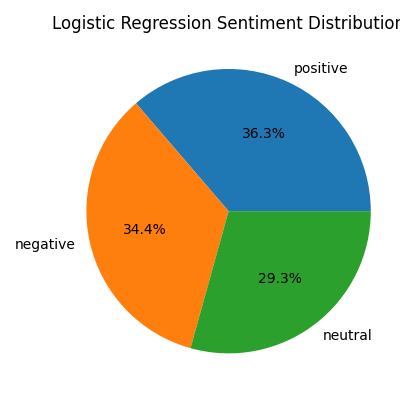

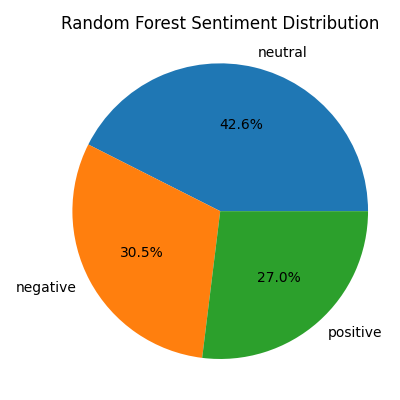

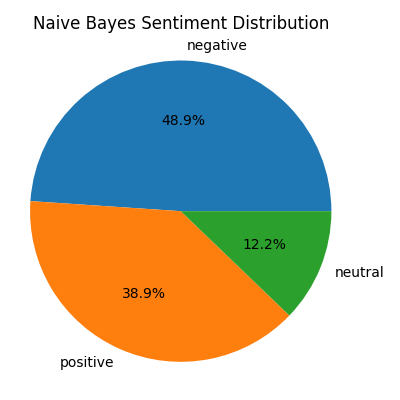

In [23]:
reports, model_preds = run_classification_model(text_full)
for model, results in reports.items():
    print(f"\n=== {model} ===")
    print("Accuracy:", results['accuracy'])
    print("Confusion Matrix:\n", results['confusion_matrix'])
    print("Classification Report:")
    print(pd.DataFrame(results['report']).transpose())

# Pie charts for classification predictions
classification_sentiment_pie(model_preds)